In [39]:
!pip install torch_geometric
!pip install nltk
!pip install gensim
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
import pandas as pd
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data, InMemoryDataset
from sklearn.model_selection import train_test_split



import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [41]:
# Load data from CSV using Pandas
dataa = pd.read_csv("/content/version1.csv")

# Create a NetworkX graph to represent your conceptual graph
conceptual_graph = nx.Graph()

# Iterate through the data and add nodes and edges to the graph
for index, row in dataa.iterrows():
    head = row["head"]
    relation = row["type"]
    tail = row["tail"]

    # Add nodes and edges to the graph
    conceptual_graph.add_node(head, type="entity")
    conceptual_graph.add_node(tail, type="entity")
    conceptual_graph.add_node(relation, type="relationship")

    # Connect nodes to represent the SVO triplets
    conceptual_graph.add_edge(head, relation)
    conceptual_graph.add_edge(relation, tail)


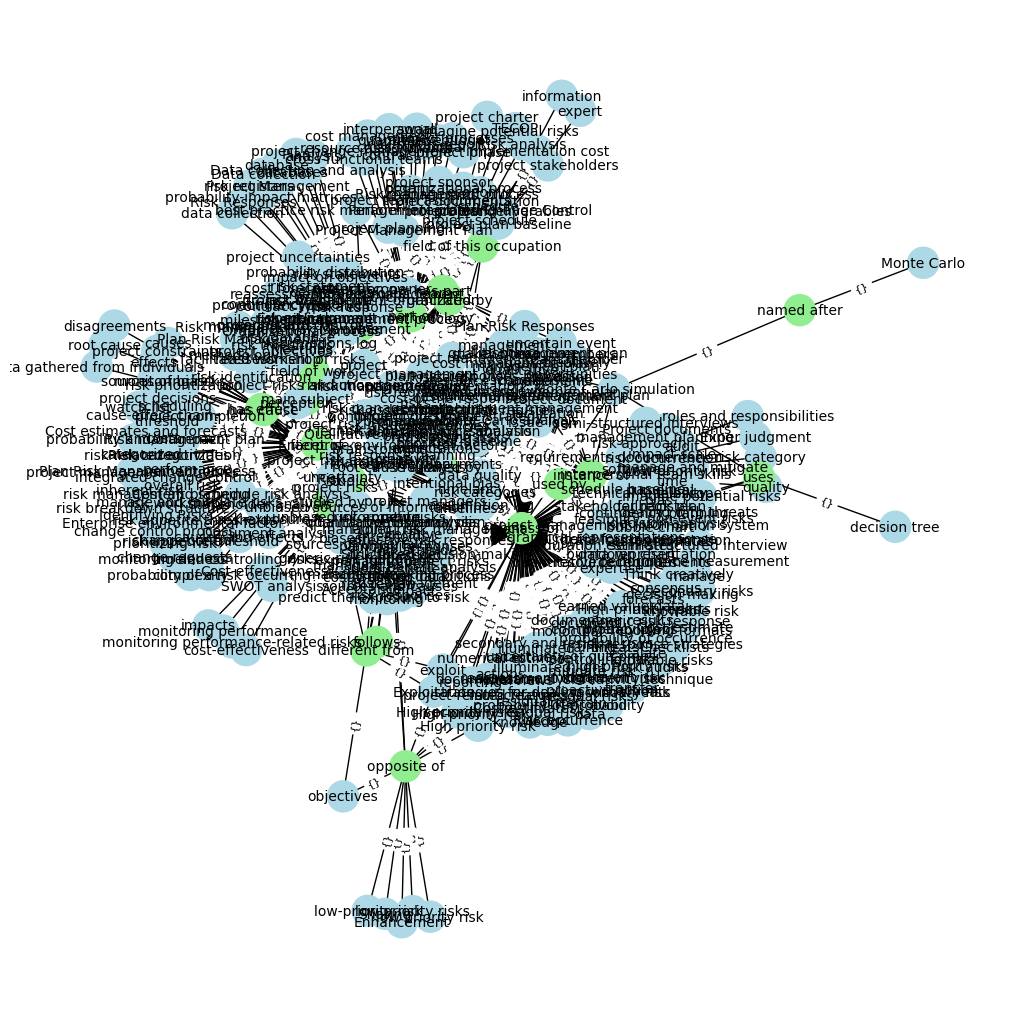

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Define a color map for node types
node_type_color_map = {"entity": "lightblue", "relationship": "lightgreen"}

# Create a figure and axis for visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(conceptual_graph, seed=42)  # You can use different layout algorithms

# Draw the nodes and edges
node_colors = [node_type_color_map.get(data["type"], "blue") for node_type, data in conceptual_graph.nodes(data=True)]
nx.draw(conceptual_graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_color='black')
edge_labels = {(u, v): d for u, v, d in conceptual_graph.edges(data=True)}
nx.draw_networkx_edge_labels(conceptual_graph, pos, edge_labels=edge_labels, font_size=8)

# Show the graph
plt.axis('off')
plt.show()



In [43]:
'''# Remove redundancies (keep only unique entities and relationships)
unique_entities = data['head'].append(data['tail']).drop_duplicates()
unique_relationships = data['type'].drop_duplicates()

# Create unique IDs for entities and relationships
entity_ids = {entity: idx for idx, entity in enumerate(unique_entities)}
relationship_ids = {relationship: idx for idx, relationship in enumerate(unique_relationships)}

# Create an adjacency matrix
num_entities = len(entity_ids)
num_relationships = len(relationship_ids)
adjacency_matrix = np.zeros((num_entities + num_relationships, num_entities + num_relationships), dtype=int)

# Populate the adjacency matrix based on connections in your data
for _, row in data.iterrows():
    head_id = entity_ids[row['head']]
    relation_id = relationship_ids[row['type']]
    tail_id = entity_ids[row['tail']]

    # Assuming directed edges from head to relation and relation to tail
    adjacency_matrix[head_id, relation_id] = 1
    adjacency_matrix[relation_id, tail_id] = 1

# Create node features based on unique IDs
node_features = torch.tensor([[1, 0] if i < num_entities else [0, 1] for i in range(num_entities + num_relationships)], dtype=torch.float32)

# Create a PyTorch Geometric Data object
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)
data = Data(x=node_features, edge_index=edge_index, edge_attr=None, y=None)'''

"# Remove redundancies (keep only unique entities and relationships)\nunique_entities = data['head'].append(data['tail']).drop_duplicates()\nunique_relationships = data['type'].drop_duplicates()\n\n# Create unique IDs for entities and relationships\nentity_ids = {entity: idx for idx, entity in enumerate(unique_entities)}\nrelationship_ids = {relationship: idx for idx, relationship in enumerate(unique_relationships)}\n\n# Create an adjacency matrix\nnum_entities = len(entity_ids)\nnum_relationships = len(relationship_ids)\nadjacency_matrix = np.zeros((num_entities + num_relationships, num_entities + num_relationships), dtype=int)\n\n# Populate the adjacency matrix based on connections in your data\nfor _, row in data.iterrows():\n    head_id = entity_ids[row['head']]\n    relation_id = relationship_ids[row['type']]\n    tail_id = entity_ids[row['tail']]\n\n    # Assuming directed edges from head to relation and relation to tail\n    adjacency_matrix[head_id, relation_id] = 1\n    adjace

In [44]:
data2=pd.read_csv("/content/version2.csv")
df = data2[["subTitle", "Ref", "PMI_subtitle", "Keywords", "relations"]]
df["node names"]=df["subTitle"]+'/'+df["PMI_subtitle"]
df = df.drop(['subTitle', 'PMI_subtitle'], axis=1)
df['features'] = df.apply(lambda row: {'ref': row['Ref'], 'keywords': row["Keywords"]}, axis=1)
df = df.drop(['Ref', 'Keywords'], axis=1)


<ipython-input-44-ab61e4efe8b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["node names"]=df["subTitle"]+'/'+df["PMI_subtitle"]


In [45]:
def preprocess_relations(relations):
    # Remove "Relations:" from the beginning of the string
    relations = relations.lstrip("Relations:")

    # Split the relations string into individual dictionaries
    relation_dicts = [x for x in relations.split('  ') if x.strip()]

    # Process each dictionary and remove the trailing '}' characters
    processed_relations = []
    for relation in relation_dicts:
        relation = relation.replace("}}", "}").rstrip('}')
        relation_dict = eval(relation)
        processed_relations.append(relation_dict)

    return processed_relations


# Apply the custom function to fix the syntax issue and convert to a list of dictionaries
df['relations'] = df['relations'].apply(preprocess_relations)


In [46]:

for index, row in df.iterrows():
    # Get the relations from the "relations" column
    relations = row['relations']

    # Create a set to track unique node names for this row
    unique_node_names = set()

    # Iterate over each dictionary in the relations
    for relation in relations:
        head = relation['head']
        tail = relation['tail']

        # Add the unique head and tail values to the set
        unique_node_names.add(head)
        unique_node_names.add(tail)

    # Convert unique_node_names to a list of strings
    unique_node_names = [str(node) for node in unique_node_names]

    # Combine the existing string with unique_node_names
    existing_node_names = row['node names']
    updated_node_names = [existing_node_names] + unique_node_names

    # Update the "node names" for this row
    df.at[index, 'node names'] = updated_node_names

In [47]:
# Define a list of stop words
stop_words = set(stopwords.words('english'))

# Initialize a stemmer
stemmer = PorterStemmer()

# Flatten and preprocess node names
node_names = [item for sublist in df['node names'] for item in sublist]
node_names = [str(name).lower() for name in node_names]

# Remove stop words and apply stemming
node_names = [stemmer.stem(word) for word in node_names if word not in stop_words]

In [48]:
featuresLIST=[]
l=list()
featuresprocess=""
features = df['features']
for feature in features:
  featuresprocess+=str(feature["keywords"])+' '+str(feature["ref"])
  featuresprocess=featuresprocess.replace(',', '').replace('[', '').replace(']', '').replace("'", '')

  featuresLIST.append(featuresprocess)





In [49]:
relations_list = []
for relations in df['relations']:
    relations_process = ' '.join([f"{triplet['head']} {triplet['type']} {triplet['tail']}" for triplet in relations])
    relations_list.append(relations_process)

# Update the 'relations' column in the DataFrame with the preprocessed data


In [50]:
df['features']=featuresLIST
df['node names'] = df['node names'].apply(lambda x: ' '.join(map(str, x)))
df['relations'] = relations_list


BERT BASE UNCASED EMBEDDING

In [51]:
!pip install transformers

In [52]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import pandas as pd

# Function to get embeddings for a given text using DistilBERT
def get_token_embeddings(text, tokenizer, model, max_seq_length, device):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Using mean pooling of token embeddings
    return embeddings.cpu().numpy().flatten()

# Assuming 'df' is your DataFrame containing chunks of data
# Define 'df' and other parameters here

# Vérifiez si le GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
max_seq_length = 512

# Chargez le modèle DistilBERT sur le GPU
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
distilbert_model = DistilBertModel.from_pretrained(model_name)
distilbert_model = distilbert_model.to(device)
num_chunks = 3
df_chunks = np.array_split(df, num_chunks)

# Process each chunk and store embeddings in separate CSV files
for i, chunk in enumerate(df_chunks):
    chunk_embeddings = pd.DataFrame()

    # Apply the function to each row in the chunk
    chunk_embeddings['Node_Names_Embeddings'] = chunk['node names'].apply(lambda x: get_token_embeddings(x, tokenizer, distilbert_model, max_seq_length, device))
    chunk_embeddings['Feature_Embeddings'] = chunk['features'].apply(lambda x: get_token_embeddings(x, tokenizer, distilbert_model, max_seq_length, device))
    chunk_embeddings['relations_Embeddings'] = chunk['relations'].apply(lambda x: get_token_embeddings(x, tokenizer, distilbert_model, max_seq_length, device))

    # Store embeddings in a CSV file
    chunk_embeddings.to_csv(f'chunk_{i+1}_embeddings.csv', index=False)


Using device: cuda


In [53]:

import pandas as pd

# Define the number of chunks
num_chunks = 3

# Initialize an empty list to store the DataFrames
dfs = []

# Load each chunk and append it to the list
for i in range(1, num_chunks + 1):
    chunk_filename = f'chunk_{i}_embeddings.csv'
    chunk_df = pd.read_csv(chunk_filename)
    dfs.append(chunk_df)

# Concatenate all DataFrames into a single DataFrame
df_combined = pd.concat(dfs, ignore_index=True)

In [54]:
from sklearn.model_selection import train_test_split

# Assuming df_combined is your combined DataFrame

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create indices for splitting
num_samples = len(df_combined)
indices = list(range(num_samples))

# Split into train and test sets
train_indices, test_indices = train_test_split(indices, test_size=1 - train_ratio, random_state=1)

# Split the test set into validation and test sets
val_indices, test_indices = train_test_split(test_indices, test_size=test_ratio / (test_ratio + val_ratio), random_state=1)

# Extract nodes based on the indices
train_nodes = df_combined.iloc[train_indices]
val_nodes = df_combined.iloc[val_indices]
test_nodes = df_combined.iloc[test_indices]

# Optionally, you may want to reset the index of the resulting DataFrames
train_nodes = train_nodes.reset_index(drop=True)
val_nodes = val_nodes.reset_index(drop=True)
test_nodes = test_nodes.reset_index(drop=True)


In [55]:
train_nodes

,Node_Names_Embeddings,Feature_Embeddings,relations_Embeddings
0,[ 8.25295150e-02 4.15095836e-02 2.67149776e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[ 1.63989633e-01 1.50685422e-02 2.21176252e-...
1,[ 1.35639831e-02 -8.06520507e-02 5.69272675e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-1.44285023e-01 -1.73591405e-01 1.15558609e-...
2,[ 4.31864001e-02 -8.33959039e-03 3.07041816e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-1.61142603e-01 -4.15982604e-02 1.02526858e-...
3,[ 8.93724188e-02 8.13724995e-02 -6.49299771e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-1.43420584e-02 3.26026604e-02 -4.47173789e-...
4,[-2.77624633e-02 2.49718837e-02 1.89506993e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-1.03612043e-01 1.42634332e-01 1.41791970e-...
...,...,...,...
67,[ 7.83360600e-02 -1.46117151e-01 3.08155239e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-2.41584629e-02 -1.69221565e-01 3.22182983e-...
68,[ 7.31016695e-02 -2.30282098e-02 2.28419602e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-7.16360891e-03 6.94751665e-02 1.94404066e-...
69,[ 1.22406475e-01 6.51033223e-02 1.58680543e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[ 9.18656737e-02 8.38250220e-02 1.68860570e-...
70,[ 1.45430952e-01 2.45768242e-02 1.72088817e-...,[-2.93840170e-01 2.39812076e-01 2.94457436e-...,[-2.50227690e-01 -3.86647647e-03 3.27420235e-...


In [56]:
train_nodes['Node_Names_Embeddings'][0]

'[ 8.25295150e-02  4.15095836e-02  2.67149776e-01  9.26285237e-02\n  2.79366910e-01 -1.82826698e-01 -9.58497077e-02  4.34764139e-02\n  9.40572917e-02 -2.18443498e-01 -1.47541493e-01  2.48065263e-01\n  1.31687813e-03 -4.11259457e-02  1.57186180e-01 -5.35891391e-04\n -5.43029383e-02  2.37567145e-02  1.61494642e-01  3.90249975e-02\n -6.43447563e-02 -8.81387070e-02 -5.40148914e-02 -2.18216121e-01\n -3.74812745e-02  1.32905424e-01  5.47336601e-02 -1.00036554e-01\n -2.38055140e-01 -4.55657020e-02  9.11603570e-02  2.70168819e-02\n  1.07532501e-01 -1.61091238e-01 -1.36786878e-01 -8.18706229e-02\n -1.78676486e-01 -5.20161763e-02 -3.44402909e-01 -9.06770155e-02\n -1.38012230e-01 -5.78723177e-02  1.02815516e-01  1.20478638e-01\n  3.48004550e-02 -7.75563270e-02 -2.11829543e-01 -2.50317186e-01\n -1.22881703e-01 -1.74337819e-01 -3.33310485e-01  1.68553084e-01\n -1.98691100e-01 -1.99460685e-01 -7.57143134e-03  1.58228993e-01\n  1.36201188e-01 -3.81010234e-01 -2.03953058e-01  6.38382584e-02\n  2.56104

In [58]:
def process_string(s):
    s = s.replace('[', '').replace(']', '')
    # Split the string by spaces and convert each part to float
    float_list = [float(x) for x in s.split()]
    # Convert the list of floats back into a string
    return float_list


In [59]:
train_nodes['Node_Names_Embeddings'] = train_nodes['Node_Names_Embeddings'].apply(process_string)
train_nodes['Feature_Embeddings'] = train_nodes['Feature_Embeddings'].apply(process_string)
train_nodes['relations_Embeddings'] = train_nodes['relations_Embeddings'].apply(process_string)


In [34]:
import ast
actual_list = ast.literal_eval(train_nodes['Node_Names_Embeddings'][0])


In [60]:
import torch

# Convert each column to a PyTorch tensor
train_nodes['Node_Names_Embeddings'] = train_nodes['Node_Names_Embeddings'].apply(torch.tensor)
train_nodes['Feature_Embeddings'] = train_nodes['Feature_Embeddings'].apply(torch.tensor)
train_nodes['relations_Embeddings'] = train_nodes['relations_Embeddings'].apply(torch.tensor)


In [ ]:
node_embeddings

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import MessagePassing

class LightGCN(MessagePassing):
    def __init__(self, num_node_names, embedding_dim=200, K=3):
        super(LightGCN, self).__init__(aggr='add')  # Set the aggregation method to 'add'
        self.num_node_names = num_node_names
        self.embedding_dim = embedding_dim
        self.K = K

        self.users_emb = nn.Embedding(num_embeddings=self.num_node_names, embedding_dim=self.embedding_dim)
        self.items_emb = nn.Embedding(num_embeddings=self.num_node_names, embedding_dim=self.embedding_dim)

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index):
        edge_index_norm = self.normalize(edge_index, num_nodes=self.num_node_names)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0]

        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_node_names, self.num_node_names])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def normalize(self, edge_index, num_nodes):
        row, col = edge_index
        deg = torch.zeros(num_nodes, dtype=torch.float32, device=edge_index.device)
        deg.index_add_(0, row, torch.ones(col.size(0), device=edge_index.device))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return norm.to(torch.float32)  # Remove the .long() conversion

In [ ]:
def bpr_loss(users_emb_final,
             users_emb_0,
             pos_items_emb_final,
             pos_items_emb_0,
             neg_items_emb_final,
             neg_items_emb_0,
             lambda_val):

    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    loss = bpr_loss + reg_loss

    return loss

In [ ]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, df):
        self.node_names_embeddings = self.flatten_embeddings(df['Node_Names_Embeddings'])
        self.feature_embeddings = self.flatten_embeddings(df['Feature_Embeddings'])
        self.relations_embeddings = self.flatten_embeddings(df['relations_Embeddings'])

    def __len__(self):
        return len(self.node_names_embeddings)

    def __getitem__(self, idx):
        return (
            self.node_names_embeddings[idx],
            self.feature_embeddings[idx],
            self.relations_embeddings[idx]
        )

    def flatten_embeddings(self, embeddings):
        flattened = []
        for item in embeddings:
            for sublist in item:
                if isinstance(sublist, list):  # Check if sublist is a list
                    for inner_sublist in sublist:
                        if isinstance(inner_sublist, list):  # Check if inner_sublist is a list
                            flattened.extend(inner_sublist)
                        else:
                            flattened.append(inner_sublist)
                else:
                    flattened.append(sublist)
        return torch.tensor(flattened)


In [ ]:
import torch

def flatten_embeddings(embeddings):
    flattened = []
    for item_list in embeddings:
        for item in item_list:
            for sublist in item:
                if isinstance(sublist, list):
                    flattened.extend(sublist)
                else:
                    flattened.append(sublist)
    return torch.tensor(flattened)

# Update Node_Names_Embeddings column
df_combined['Node_Names_Embeddings'] = df_combined['Node_Names_Embeddings'].apply(flatten_embeddings)

# Update Feature_Embeddings column
df_combined['Feature_Embeddings'] = df_combined['Feature_Embeddings'].apply(flatten_embeddings)

# Update relations_Embeddings column
df_combined['relations_Embeddings'] = df_combined['relations_Embeddings'].apply(flatten_embeddings)


In [ ]:
from torch_geometric.loader import DataLoader

# Assuming your DataFrame is named 'df'
my_dataset = MyDataset(df_combined)

# Initialize DataLoader for batch processing
train_loader = DataLoader(my_dataset, batch_size=16, shuffle=True)

# Example usage:
for data in train_loader:
    node_names_embed, feature_embed, relation_embed = data

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch_geometric.data import Data

# Assuming you have your data stored in the variables train_nodes, val_nodes, test_nodes, train_edge_index

# Convert data to PyTorch tensors
train_edge_index = torch.tensor(train_nodes, dtype=torch.long)
val_edge_index = torch.tensor(val_nodes, dtype=torch.long)
test_edge_index = torch.tensor(test_nodes, dtype=torch.long)

# Instantiate the model
num_node_names = 886
layers = 3
model = LightGCN(num_node_names=num_node_names, K=layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Forward pass
    users_emb_final, _, items_emb_final, _ = model(train_edge_index)

    # Compute the loss
    loss = criterion(users_emb_final, items_emb_final)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation during training (optional)
    with torch.no_grad():
        val_users_emb_final, _, val_items_emb_final, _ = model(val_edge_index)
        val_loss = criterion(val_users_emb_final, val_items_emb_final)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Evaluation on the test set
with torch.no_grad():
    test_users_emb_final, _, test_items_emb_final, _ = model(test_edge_index)
    test_loss = criterion(test_users_emb_final, test_items_emb_final)

    print(f'Test Loss: {test_loss.item()}')
